## Siemens Window Optimazation

**Index**

1. Loading the datasets
2. Transposing the time series datasets
3. Merging time series datasets to add additional features
4. Window extraction
5. Slope Calculation and Window Optimization
   - 5.1. Sensor A
   - 5.2. Sensor B   

# 1. Loading the datasets

In [1]:
#!pip install scikit-fda

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import random
from sklearn.decomposition import PCA
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.projection import FPCA
from sklearn.preprocessing import OneHotEncoder
import skfda
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import FDataBasis, FourierBasis

/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_86499/2677705551.py:9: DeprecationWarning: The module "projection" is deprecated. Please use "dim_reduction"
  from skfda.preprocessing.dim_reduction.projection import FPCA


# 2. Transposing the time series datasets

You can change this part based on where you store the data

In [3]:
# # Import datasets
# sensorA_System1 = pd.read_csv("RawData/System1_SensorA.csv")
# sensorA_System2 = pd.read_csv("RawData/System2_SensorA.csv")
# sensorB_System1 = pd.read_csv("RawData/System1_SensorB.csv")
# sensorB_System2 = pd.read_csv("RawData/System2_SensorB.csv")
# sensorA_System1_missing = pd.read_csv("RawData/SensorA_System1_missing values.csv")
# sensorA_System2_missing = pd.read_csv("RawData/SensorA_System2_missing values.csv")
# keyByTestID = pd.read_csv("RawData/Key by TestID.csv", parse_dates=['DateTime'])

# Import datasets
sensorA_System1 = pd.read_csv("../../../RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("../../../RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("../../../RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("../../../RawData/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv("../../../RawData/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv("../../../RawData/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv("../../../RawData/Key by TestID.csv", parse_dates=['DateTime'])

# 3. Merging time series datasets to add additional features

In [4]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [5]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

In [6]:
# Create new column to fill fluid temperature NA's
# Note: Fluid temperature: If specified, take as the temperature of the sample fluid. The rest of the system temperature can be taken as ambient temperature.

keyByTestID['Fluid_Temperature_Filled'] = keyByTestID['Fluid Temperature'].combine_first(keyByTestID['AmbientTemperature'])
keyByTestID.head(3)

,TestID,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode,Fluid_Temperature_Filled
0,3550995,Eurotrol L1,2024-02-07 10:32:15,16-23333-20,302910,70,73,180.4,178.8,System 2A,Sensor A,21.2345,NaN,NaN,Success,NoError,NoError,Success,21.2345
1,3550995,Eurotrol L1,2024-02-07 10:32:15,16-23333-20,302910,70,73,180.4,178.8,System 2A,Sensor B,21.2345,NaN,NaN,Success,NoError,NoError,Success,21.2345
2,3551012,Eurotrol L1,2024-02-07 10:41:33,16-23333-20,303096,70,73,183.2,181.6,System 2A,Sensor A,21.5012,NaN,NaN,Success,NoError,NoError,Success,21.5012


In [7]:
# Relabeling System Values
keyByTestID["System"] = keyByTestID["System"].replace({"System 2A":"System 2","System 2B":"System 2"})
keyByTestID.tail(3)

,TestID,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode,Fluid_Temperature_Filled
24255,3518677,HNB,2023-09-19 16:54:21,16-23151-20,302186,111,23,459.0,454.8,System 2,Sensor B,25.2250,15.0,NaN,Success,NoError,NoError,Success,15.0
24256,3518678,HNB,2023-09-19 16:54:23,16-23137-20,300820,125,33,459.2,455.2,System 2,Sensor A,24.4908,15.0,NaN,Success,NoError,NoError,Success,15.0
24257,3518678,HNB,2023-09-19 16:54:23,16-23137-20,300820,125,33,459.2,455.2,System 2,Sensor B,24.4908,15.0,NaN,Success,NoError,NoError,Success,15.0


In [8]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3382, 3377)
A2:  (7743, 3368)
B1:  (3375, 3377)
B2:  (7745, 3368)


In [9]:
# Remove the testID only exists in one sensor
# Only run once
A1_Merged = A1_Merged[A1_Merged["TestID"].isin(B1_Merged["TestID"])]
B1_Merged = B1_Merged[B1_Merged["TestID"].isin(A1_Merged["TestID"])]

A2_Merged = A2_Merged[A2_Merged["TestID"].isin(B2_Merged["TestID"])]
B2_Merged = B2_Merged[B2_Merged["TestID"].isin(A2_Merged["TestID"])]
print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3374, 3377)
A2:  (7743, 3368)
B1:  (3374, 3377)
B2:  (7743, 3368)


# 4. Window extraction

In [10]:
def calculate_window_values(bubble_start, sample_start, calDelimit_input, cal_window_size_input, sampleDelimit_input, sample_window_size_input):
    """
    Calculate the start and end values for calibration and sample windows based on given start points and delimiters.

    Parameters:
    -----------
    bubble_start : float
        The starting point for the bubble (reference point for calibration).
    sample_start : float
        The starting point for the sample.
    calDelimit_input : float
        The delimiter value to adjust the starting point of the calibration window.
    cal_window_size_input : float
        The size of the calibration window.
    sampleDelimit_input : float
        The delimiter value to adjust the starting point of the sample window.
    sample_window_size_input : float
        The size of the sample window.

    Returns:
    --------
    tuple of float
        A tuple containing four values:
        - cal_window_start: The starting position of the calibration window, rounded to one decimal place.
        - cal_window_end: The ending position of the calibration window, rounded to one decimal place.
        - sample_window_start: The starting position of the sample window, rounded to one decimal place.
        - sample_window_end: The ending position of the sample window, rounded to one decimal place.
    """
    cal_window_start = bubble_start - calDelimit_input
    cal_window_end = cal_window_start + cal_window_size_input
    sample_window_start = sample_start + sampleDelimit_input
    sample_window_end = sample_window_start + sample_window_size_input
    return round(cal_window_start, 1), round(cal_window_end, 1), round(sample_window_start, 1), round(sample_window_end, 1)

def calculate_window_data(row):
    """
    Extract calibration and sample window data from a given row of time series data.

    Parameters:
    -----------
    row : pd.Series
        A pandas Series object containing time series data and window start/end times.
        The Series should have the following structure:
        - 'cal_window_start': The start time for the calibration window.
        - 'cal_window_end': The end time for the calibration window.
        - 'sample_window_start': The start time for the sample window.
        - 'sample_window_end': The end time for the sample window.
        - The index from position 19 to -5 should contain the timestamps (as float) of the time series data.

    Returns:
    --------
    tuple of pd.Series
        A tuple containing two pandas Series:
        - The first Series corresponds to the data within the calibration window.
        - The second Series corresponds to the data within the sample window.
    """
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[19:-5].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window], row[sample_window]

def process_sensor_data(merged_df, calDelimit, cal_window_size, sampleDelimit, sample_window_size, sampleDelimit_aqueous=None):
    """
    Process sensor data by calculating window values and extracting window data for each test.

    Parameters:
    -----------
    merged_df : pd.DataFrame
        The merged DataFrame containing sensor data and time series information.
    calDelimit : float
        The delimiter value to adjust the starting point of the calibration window.
    cal_window_size : float
        The size of the calibration window.
    sampleDelimit : float
        The delimiter value to adjust the starting point of the sample window.
    sample_window_size : float
        The size of the sample window.
    sampleDelimit_aqueous : float, optional
        The delimiter value to adjust the starting point of the sample window for aqueous samples (default is None).

    Returns:
    --------
    tuple of pd.DataFrame
        A tuple containing two DataFrames:
        - The first DataFrame corresponds to the calibration window data for each test.
        - The second DataFrame corresponds to the sample window data for each test.
    """
    # Calculate window values
    if sampleDelimit_aqueous != None:
        merged_df['cal_window_start'], merged_df['cal_window_end'], \
        merged_df['sample_window_start'], merged_df['sample_window_end'] = zip(*merged_df.apply(
            lambda row: calculate_window_values(
                bubble_start=row['BubbleDetectTime'],
                sample_start=row['SampleDetectTime'],
                calDelimit_input=calDelimit,
                cal_window_size_input=cal_window_size,
                sampleDelimit_input=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit,
                sample_window_size_input=sample_window_size
            ), axis=1))
    else:
        merged_df['cal_window_start'], merged_df['cal_window_end'], \
        merged_df['sample_window_start'], merged_df['sample_window_end'] = zip(*merged_df.apply(
            lambda row: calculate_window_values(
                bubble_start=row['BubbleDetectTime'],
                sample_start=row['SampleDetectTime'],
                calDelimit_input=calDelimit,
                cal_window_size_input=cal_window_size,
                sampleDelimit_input=sampleDelimit,
                sample_window_size_input=sample_window_size
            ), axis=1))

    # Extract window data
    cal_window_list = []
    sample_window_list = []
    for i in range(len(merged_df)):
        cal_window, sample_window = calculate_window_data(merged_df.iloc[i, :])
        cal_window_list.append(cal_window.values)
        sample_window_list.append(sample_window.values)

    cal_window_df = pd.DataFrame(cal_window_list)
    sample_window_df = pd.DataFrame(sample_window_list)
    cal_window_df['TestID'] = sample_window_df['TestID'] = merged_df['TestID'].astype(int)
    sample_window_df.set_index('TestID', inplace=True)
    cal_window_df.set_index('TestID', inplace=True)

    return cal_window_df, sample_window_df


In [11]:
# Usage for System 1 and System 2 for Sensors A and B
calDelimit_A = 11
cal_window_size_A = 8
sampleDelimit_A = 15
sample_window_size_A = 5

calDelimit_B = 20
cal_window_size_B = 18
sampleDelimit_B_blood = 24
sampleDelimit_B_aqueous = 30
sample_window_size_B = 4

B1_Merged_blood = B1_Merged[~B1_Merged['FluidType'].str.startswith('Eurotrol')]
B1_Merged_aqueous = B1_Merged[B1_Merged['FluidType'].str.startswith('Eurotrol')]
B2_Merged_blood = B2_Merged[~B2_Merged['FluidType'].str.startswith('Eurotrol')]
B2_Merged_aqueous = B2_Merged[B2_Merged['FluidType'].str.startswith('Eurotrol')]

A1_cal_window, A1_sample_window = process_sensor_data(A1_Merged, calDelimit_A, cal_window_size_A, sampleDelimit_A, sample_window_size_A)
A2_cal_window, A2_sample_window = process_sensor_data(A2_Merged, calDelimit_A, cal_window_size_A, sampleDelimit_A, sample_window_size_A)

B1_cal_window, B1_sample_window = process_sensor_data(B1_Merged, calDelimit_B, cal_window_size_B, sampleDelimit_B_blood, sample_window_size_B, sampleDelimit_B_aqueous)
B2_cal_window, B2_sample_window = process_sensor_data(B2_Merged, calDelimit_B, cal_window_size_B, sampleDelimit_B_blood, sample_window_size_B, sampleDelimit_B_aqueous)

B1_cal_window_blood, B1_sample_window_blood = process_sensor_data(B1_Merged_blood, calDelimit_B, cal_window_size_B, sampleDelimit_B_blood, sample_window_size_B)
B2_cal_window_blood, B2_sample_window_blood = process_sensor_data(B2_Merged_blood, calDelimit_B, cal_window_size_B, sampleDelimit_B_blood, sample_window_size_B)

B1_cal_window_aqueous, B1_sample_window_aqueous = process_sensor_data(B1_Merged_aqueous, calDelimit_B, cal_window_size_B, sampleDelimit_B_blood, sample_window_size_B, sampleDelimit_B_aqueous)
B2_cal_window_aqueous, B2_sample_window_aqueous = process_sensor_data(B2_Merged_aqueous, calDelimit_B, cal_window_size_B, sampleDelimit_B_blood, sample_window_size_B, sampleDelimit_B_aqueous)

/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_86499/3319096739.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['cal_window_start'], merged_df['cal_window_end'], \
/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_86499/3319096739.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['cal_window_start'], merged_df['cal_window_end'], \
/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_86499/3319096739.py:106: SettingWithCopyWarning: 
A value is trying t

# 5. Slope Calculation and Window Optimization

In [12]:
from sklearn.linear_model import LinearRegression

def calculate_column_means(df1, df2):
    """
    Calculate the column means of two DataFrames.

    Parameters:
    -----------
    df1 : pd.DataFrame
        The first DataFrame.
    df2 : pd.DataFrame
        The second DataFrame.

    Returns:
    --------
    tuple of pd.Series
        A tuple containing two Series:
        - The first Series corresponds to the column means of the first DataFrame.
        - The second Series corresponds to the column means of the second DataFrame.
    """
    mean_df1 = df1.mean(axis=0)
    mean_df2 = df2.mean(axis=0)
    return mean_df1, mean_df2

def calculate_slope(column_means):
    """
    Calculate the slope using Simple Linear Regression (SLR) on the given column means.

    Parameters:
    -----------
    column_means : pd.Series
        A Series containing the column means.

    Returns:
    --------
    float
        The slope calculated using SLR.
    """
    # Drop NaN values
    column_means = column_means.dropna()

    # Check if column_means is empty after dropping NaNs
    if column_means.empty:
        return np.nan

    x = np.arange(len(column_means)).reshape(-1, 1)
    y = column_means.values
    reg = LinearRegression().fit(x, y)
    return reg.coef_[0]

def difference_of_slopes(df1, df2):
    """
    Calculate the difference between the slopes of two DataFrames based on their column means using SLR.

    Parameters:
    -----------
    df1 : pd.DataFrame
        The first DataFrame.
    df2 : pd.DataFrame
        The second DataFrame.

    Returns:
    --------
    float
        The difference between the slopes calculated using SLR on the column means of the two DataFrames.
    """
    mean_df1, mean_df2 = calculate_column_means(df1, df2)
    slope1 = calculate_slope(mean_df1)
    slope2 = calculate_slope(mean_df2)
    return slope1 - slope2


In [13]:
def plot_singletest_with_windows(df, TestID, calDelimit, sampleDelimit, cal_window_size, sample_window_size):
    """
    Plots the values of a specified row in a DataFrame, marking the calibration and sample window start and end times with vertical lines.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - row_index (int): The ID of the test to plot.
    - calDelimit (decimal): The value of the new calDelimit.
    - sampleDelimit (decimal): The value of the new sampleDelimit.

    Returns:
    - Plot
    """
    row = df[df['TestID']==TestID]
    
    cal_window_start = row['cal_window_start']
    cal_window_end = row['cal_window_end']
    sample_window_start = row['sample_window_start']
    sample_window_end = row['sample_window_end']

    new_cal_window_start, new_cal_window_end, new_sample_window_start, new_sample_window_end = calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit_input=calDelimit,
        cal_window_size_input=cal_window_size,
        sampleDelimit_input=sampleDelimit,
        sample_window_size_input=sample_window_size)
    
    # Extract the time series data from the row
    timestamps = row.columns[750:-5].values.astype(float)
    values = row.iloc[:,750:-5].T.values
    
    plt.figure(figsize=(10, 6))
    
    # Plot the time series data
    plt.plot(timestamps, values, label='Time Series Data', marker='o')
    
    # Mark the calibration window
    plt.axvline(x=cal_window_start.values, color='r', linestyle='--', label='Calibration Window')
    plt.axvline(x=cal_window_end.values, color='r', linestyle='--')

    plt.axvline(x=new_cal_window_start.values, color='g', linestyle='--', label='New Calibration Window')
    plt.axvline(x=new_cal_window_end.values, color='g', linestyle='--')
    
    # Mark the sample window
    plt.axvline(x=sample_window_start.values, color='b', linestyle='--', label='Sample Window')
    plt.axvline(x=sample_window_end.values, color='b', linestyle='--')

    plt.axvline(x=new_sample_window_start.values, color='m', linestyle='--', label='New Sample Window')
    plt.axvline(x=new_sample_window_end.values, color='m', linestyle='--')

    # Adding title and labels
    plt.title(f'Test {TestID} with Calibration and Sample Windows')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    
    # Display the plot
    plt.show()


## 5.1. Sensor A

In [ ]:
diff_slopes_result_A_cal = {}
diff_slopes_result_A_sample = {}
# Cal window for sensor A
for delimit in np.arange(8, 13.2, 0.2):
    A2_cal_window_new, _ = process_sensor_data(A2_Merged, delimit, cal_window_size_A, delimit, sample_window_size_A)
    diff_slopes_cal = difference_of_slopes(A1_cal_window, A2_cal_window_new)
    diff_slopes_result_A_cal[round(delimit,2)] = {
        'diff_slopes_cal': diff_slopes_cal,
    }

# Sample window for sensor A
for delimit in np.arange(13, 20.2, 0.2):
    _, A2_sample_window_new = process_sensor_data(A2_Merged, delimit, cal_window_size_A, delimit, sample_window_size_A)
    diff_slopes_sample = difference_of_slopes(A1_sample_window, A2_sample_window_new)
    diff_slopes_result_A_sample[round(delimit,2)] = {
        'diff_slopes_sample': diff_slopes_sample
    }

In [155]:
print(pd.DataFrame(diff_slopes_result_A_cal))
print(pd.DataFrame(diff_slopes_result_A_sample))

                     8.0       8.2       8.4       8.6       8.8       9.0   \
diff_slopes_cal  0.003467  0.003902  0.003925  0.003761  0.003565  0.003412   

                   9.2       9.4       9.6       9.8   ...      11.2  \
diff_slopes_cal  0.0033  0.003244  0.003224  0.003228  ...  0.003388   

                     11.4     11.6      11.8     12.0      12.2      12.4  \
diff_slopes_cal  0.003405  0.00342  0.003436  0.00345  0.003465  0.003481   

                     12.6      12.8      13.0  
diff_slopes_cal  0.003496  0.003511  0.003527  

[1 rows x 26 columns]
                        13.0      13.2      13.4      13.6      13.8  \
diff_slopes_sample -0.007513 -0.007423 -0.007321 -0.007212 -0.007095   

                        14.0      14.2      14.4      14.6      14.8  ...  \
diff_slopes_sample -0.006969 -0.006839 -0.006703 -0.006567 -0.006428  ...   

                        18.2      18.4      18.6      18.8      19.0  \
diff_slopes_sample -0.005947 -0.006025 -0.006084 -

In [172]:
# Initialize variables to store the minimum absolute values and corresponding keys
min_abs_diff_slopes_cal = float('inf')
min_abs_diff_slopes_sample = float('inf')
min_abs_diff_slopes_cal_key = None
min_abs_diff_slopes_sample_key = None

# Iterate through the dictionary to find the absolute minimum values and their keys
for key, result in diff_slopes_result_A_cal.items():
    abs_diff_slopes_cal = abs(result['diff_slopes_cal'])
    
    if abs_diff_slopes_cal < min_abs_diff_slopes_cal:
        min_abs_diff_slopes_cal = abs_diff_slopes_cal
        min_abs_diff_slopes_cal_key = key

for key, result in diff_slopes_result_A_sample.items():
    abs_diff_slopes_sample = abs(result['diff_slopes_sample'])
    
    if abs_diff_slopes_sample < min_abs_diff_slopes_sample:
        min_abs_diff_slopes_sample = abs_diff_slopes_sample
        min_abs_diff_slopes_sample_key = key

# Print the results
print(f"Absolute minimum value of diff_slopes_cal: {min_abs_diff_slopes_cal:.4f} (Key: {min_abs_diff_slopes_cal_key})")
print(f"Absolute minimum value of diff_slopes_sample: {min_abs_diff_slopes_sample:.4f} (Key: {min_abs_diff_slopes_sample_key})")

Absolute minimum value of diff_slopes_cal: 0.0032 (Key: 9.6)
Absolute minimum value of diff_slopes_sample: 0.0053 (Key: 17.2)


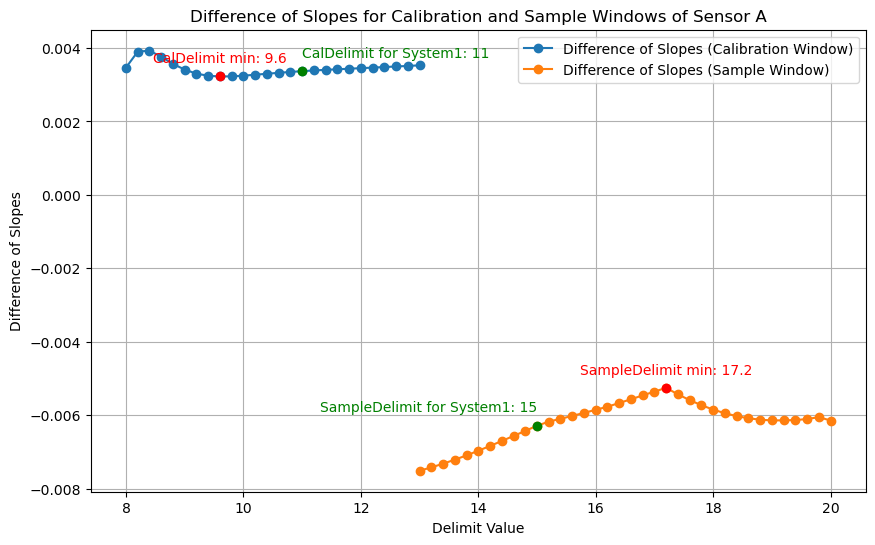

In [175]:
# Extract delimit values and corresponding differences in slopes
delimits_cal = list(diff_slopes_result_A_cal.keys())
delimits_sample = list(diff_slopes_result_A_sample.keys())
diff_slopes_cal = [diff_slopes_result_A_cal[delimit]['diff_slopes_cal'] for delimit in delimits_cal]
diff_slopes_sample = [diff_slopes_result_A_sample[delimit]['diff_slopes_sample'] for delimit in delimits_sample]

# Create a plot
plt.figure(figsize=(10, 6))

# Plot diff_slopes_cal
plt.plot(delimits_cal, diff_slopes_cal, label='Difference of Slopes (Calibration Window)', marker='o')

# Plot diff_slopes_sample
plt.plot(delimits_sample, diff_slopes_sample, label='Difference of Slopes (Sample Window)', marker='o')

# Mark the minimum absolute values
plt.scatter(min_abs_diff_slopes_cal_key, diff_slopes_result_A_cal[min_abs_diff_slopes_cal_key]['diff_slopes_cal'],
            color='red', zorder=5)
plt.scatter(calDelimit_A, diff_slopes_result_A_cal[calDelimit_A]['diff_slopes_cal'],
            color='green', zorder=5)
plt.scatter(min_abs_diff_slopes_sample_key, diff_slopes_result_A_sample[min_abs_diff_slopes_sample_key]['diff_slopes_sample'],
            color='red', zorder=5)
plt.scatter(sampleDelimit_A, diff_slopes_result_A_sample[sampleDelimit_A]['diff_slopes_sample'],
            color='green', zorder=5)

# Annotate the points with minimum values
plt.annotate(f'CalDelimit min: {min_abs_diff_slopes_cal_key}',
             (min_abs_diff_slopes_cal_key, diff_slopes_result_A_cal[min_abs_diff_slopes_cal_key]['diff_slopes_cal']),
             textcoords="offset points", xytext=(0,10), ha='center', color='red')
plt.annotate(f'CalDelimit for System1: {calDelimit_A}',
             (calDelimit_A, diff_slopes_result_A_cal[calDelimit_A]['diff_slopes_cal']),
             textcoords="offset points", xytext=(0,10), ha='left', color='green')
plt.annotate(f'SampleDelimit min: {min_abs_diff_slopes_sample_key}',
             (min_abs_diff_slopes_sample_key, diff_slopes_result_A_sample[min_abs_diff_slopes_sample_key]['diff_slopes_sample']),
             textcoords="offset points", xytext=(0,10), ha='center', color='red')
plt.annotate(f'SampleDelimit for System1: {sampleDelimit_A}',
             (sampleDelimit_A, diff_slopes_result_A_sample[sampleDelimit_A]['diff_slopes_sample']),
             textcoords="offset points", xytext=(0,10), ha='right', color='green')

# Adding title and labels
plt.title('Difference of Slopes for Calibration and Sample Windows of Sensor A')
plt.xlabel('Delimit Value')
plt.ylabel('Difference of Slopes')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

From the plot above, we can see the suggested new CalDelimit of Sensor A for System 2 is 9.6, and the suggested new SampleDelimit of Sensor A for System 2 is 17.2

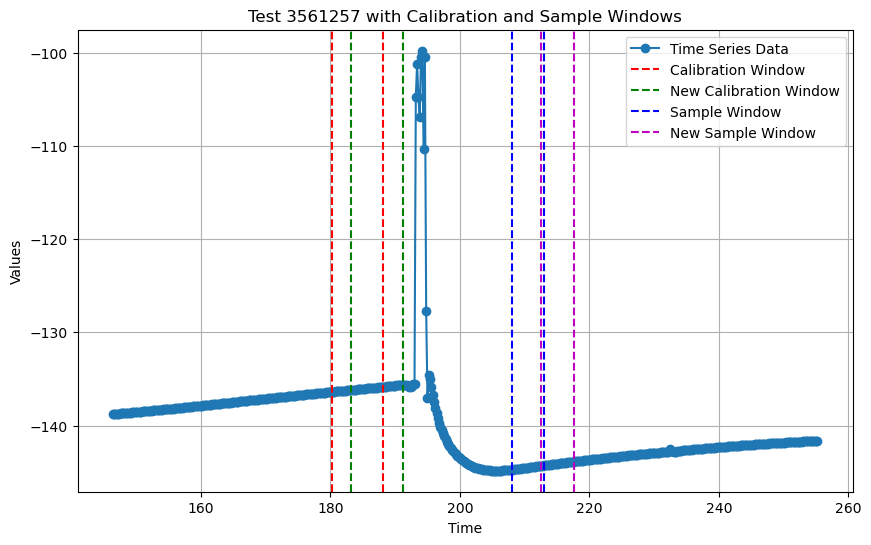

In [15]:
# Random sample one TestID for sensor A in System 2
randomTestID=A2_Merged['TestID'].sample(1).values[0]
plot_singletest_with_windows(A2_Merged,randomTestID,calDelimit=9.6,sampleDelimit=17.2,cal_window_size=cal_window_size_A,sample_window_size=sample_window_size_A)

## 5.2. Sensor B

### 5.2.1. Sensor B - Cal window

In [159]:
diff_slopes_result_B_cal = {}
for delimit in np.arange(18, 22.2, 0.2):
    B2_cal_window_new, _ = process_sensor_data(B2_Merged, delimit, cal_window_size_B, delimit, sample_window_size_B, delimit)
    diff_slopes_cal = difference_of_slopes(B1_cal_window, B2_cal_window_new)
    diff_slopes_result_B_cal[round(delimit,2)] = {
        'diff_slopes_cal': diff_slopes_cal,
    }

In [176]:
# Initialize variables to store the minimum absolute values and corresponding keys
min_abs_diff_slopes_cal = float('inf')
min_abs_diff_slopes_cal_key = None

# Iterate through the dictionary to find the absolute minimum values and their keys
for key, result in diff_slopes_result_B_cal.items():
    abs_diff_slopes_cal = abs(result['diff_slopes_cal'])
    
    if abs_diff_slopes_cal < min_abs_diff_slopes_cal:
        min_abs_diff_slopes_cal = abs_diff_slopes_cal
        min_abs_diff_slopes_cal_key = key
    

# Print the results
print(f"Absolute minimum value of diff_slopes_cal: {min_abs_diff_slopes_cal:.4f} (Key: {min_abs_diff_slopes_cal_key})")

Absolute minimum value of diff_slopes_cal: 0.0070 (Key: 18.0)


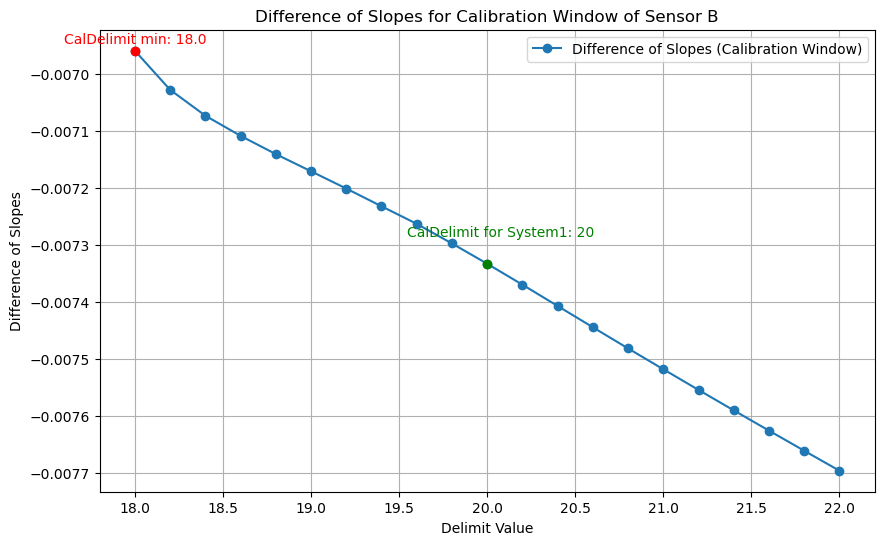

In [182]:
# Extract delimit values and corresponding differences in slopes
delimits = list(diff_slopes_result_B_cal.keys())
diff_slopes_cal = [diff_slopes_result_B_cal[delimit]['diff_slopes_cal'] for delimit in delimits]

# Create a plot
plt.figure(figsize=(10, 6))

# Plot diff_slopes_cal
plt.plot(delimits, diff_slopes_cal, label='Difference of Slopes (Calibration Window)', marker='o')


# Mark the minimum absolute values
plt.scatter(min_abs_diff_slopes_cal_key, diff_slopes_result_B_cal[min_abs_diff_slopes_cal_key]['diff_slopes_cal'],
            color='red', zorder=5)
plt.scatter(calDelimit_B, diff_slopes_result_B_cal[calDelimit_B]['diff_slopes_cal'],
            color='green', zorder=5)
# Annotate the points with minimum values
plt.annotate(f'CalDelimit min: {min_abs_diff_slopes_cal_key}',
             (min_abs_diff_slopes_cal_key, diff_slopes_result_B_cal[min_abs_diff_slopes_cal_key]['diff_slopes_cal']),
             textcoords="offset points", xytext=(0,5), ha='center', color='red')
plt.annotate(f'CalDelimit for System1: {calDelimit_B}',
             (calDelimit_B, diff_slopes_result_B_cal[calDelimit_B]['diff_slopes_cal']),
             textcoords="offset points", xytext=(10,20), ha='center', color='green')

# Adding title and labels
plt.title('Difference of Slopes for Calibration Window of Sensor B')
plt.xlabel('Delimit Value')
plt.ylabel('Difference of Slopes')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


From the plot above, we can see the suggested new CalDelimit of Sensor B for System 2 is 18.

### 5.2.2. Sensor B - Sample window

In [163]:
diff_slopes_result_B_sample_blood = {}
diff_slopes_result_B_sample_aqueous = {}
for delimit in np.arange(20,24.2,0.2):
    _, B2_sample_window_blood_new = process_sensor_data(B2_Merged_blood, delimit, cal_window_size_B, delimit, sample_window_size_B, delimit)
    diff_slopes_sample_blood = difference_of_slopes(B1_sample_window_blood, B2_sample_window_blood_new)
    diff_slopes_result_B_sample_blood[round(delimit,2)] = {
        'diff_slopes_sample_blood': diff_slopes_sample_blood,
    }
for delimit in np.arange(28,34.2,0.2):
    _, B2_sample_window_aqueous_new = process_sensor_data(B2_Merged_aqueous, delimit, cal_window_size_B, delimit, sample_window_size_B, delimit)
    diff_slopes_sample_aqueous = difference_of_slopes(B1_sample_window_aqueous, B2_sample_window_aqueous_new)
    diff_slopes_result_B_sample_aqueous[round(delimit,2)] = {
        'diff_slopes_sample_aqueous': diff_slopes_sample_aqueous
    }

/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_46272/97189566.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['cal_window_start'], merged_df['cal_window_end'], \
/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_46272/97189566.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['sample_window_start'], merged_df['sample_window_end'] = zip(*merged_df.apply(
/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_46272/97189566.py:94: SettingWithCopyWarning: 
A

In [183]:
# Initialize variables to store the minimum absolute values and corresponding keys
min_abs_diff_slopes_sample_blood = float('inf')
min_abs_diff_slopes_sample_aqueous = float('inf')
min_abs_diff_slopes_sample_blood_key = None
min_abs_diff_slopes_sample_aqueous_key = None

# Iterate through the dictionary to find the absolute minimum values and their keys
for key, result in diff_slopes_result_B_sample_blood.items():
    abs_diff_slopes_sample_blood = abs(result['diff_slopes_sample_blood'])
    #abs_diff_slopes_sample_aqueous = abs(result['diff_slopes_sample_aqueous'])
    
    if abs_diff_slopes_sample_blood < min_abs_diff_slopes_sample_blood:
        min_abs_diff_slopes_sample_blood = abs_diff_slopes_sample_blood
        min_abs_diff_slopes_sample_blood_key = key
    
    # if abs_diff_slopes_sample_aqueous < min_abs_diff_slopes_sample_aqueous:
    #     min_abs_diff_slopes_sample_aqueous = abs_diff_slopes_sample_aqueous
    #     min_abs_diff_slopes_sample_aqueous_key = key

for key, result in diff_slopes_result_B_sample_aqueous.items():
    #abs_diff_slopes_sample_blood = abs(result['diff_slopes_sample_blood'])
    abs_diff_slopes_sample_aqueous = abs(result['diff_slopes_sample_aqueous'])
    
    # if abs_diff_slopes_sample_blood < min_abs_diff_slopes_sample_blood:
    #     min_abs_diff_slopes_sample_blood = abs_diff_slopes_sample_blood
    #     min_abs_diff_slopes_sample_blood_key = key
    
    if abs_diff_slopes_sample_aqueous < min_abs_diff_slopes_sample_aqueous:
        min_abs_diff_slopes_sample_aqueous = abs_diff_slopes_sample_aqueous
        min_abs_diff_slopes_sample_aqueous_key = key

# Print the results
print(f"Absolute minimum value of diff_slopes_sample_blood: {min_abs_diff_slopes_sample_blood:.4f} (Key: {min_abs_diff_slopes_sample_blood_key})")
print(f"Absolute minimum value of diff_slopes_sample_aqueous: {min_abs_diff_slopes_sample_aqueous:.4f} (Key: {min_abs_diff_slopes_sample_aqueous_key})")

Absolute minimum value of diff_slopes_sample_blood: 0.0081 (Key: 24.0)
Absolute minimum value of diff_slopes_sample_aqueous: 0.0092 (Key: 32.8)


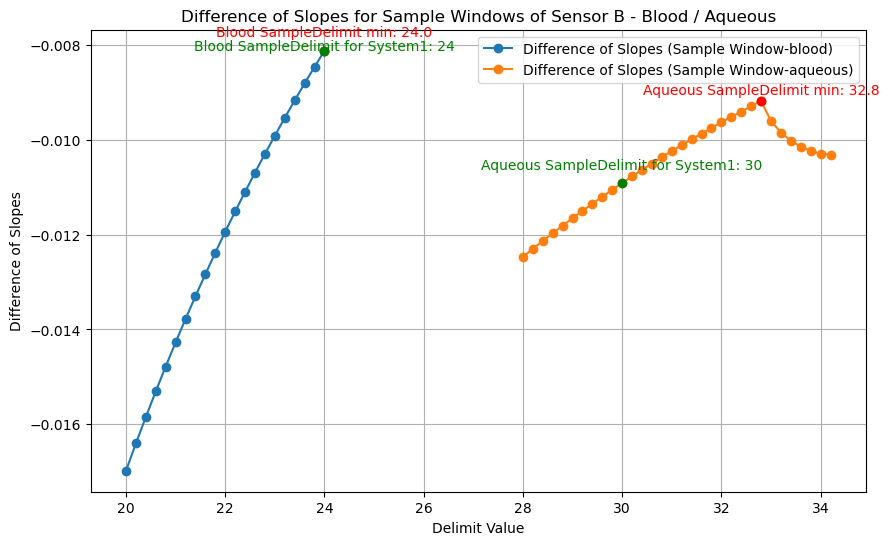

In [184]:
# Extract delimit values and corresponding differences in slopes
delimits_blood = list(diff_slopes_result_B_sample_blood.keys())
delimits_aqueous = list(diff_slopes_result_B_sample_aqueous.keys())
diff_slopes_blood = [diff_slopes_result_B_sample_blood[delimit]['diff_slopes_sample_blood'] for delimit in delimits_blood]
diff_slopes_aqueous = [diff_slopes_result_B_sample_aqueous[delimit]['diff_slopes_sample_aqueous'] for delimit in delimits_aqueous]

# Create a plot
plt.figure(figsize=(10, 6))

# Plot diff_slopes_blood
plt.plot(delimits_blood, diff_slopes_blood, label='Difference of Slopes (Sample Window-blood)', marker='o')

# Plot diff_slopes_aqueous
plt.plot(delimits_aqueous, diff_slopes_aqueous, label='Difference of Slopes (Sample Window-aqueous)', marker='o')

# Mark the minimum absolute values
plt.scatter(min_abs_diff_slopes_sample_blood_key, diff_slopes_result_B_sample_blood[min_abs_diff_slopes_sample_blood_key]['diff_slopes_sample_blood'],
            color='red', zorder=5)
plt.scatter(sampleDelimit_B_blood, diff_slopes_result_B_sample_blood[sampleDelimit_B_blood]['diff_slopes_sample_blood'],
            color='green', zorder=5)
plt.scatter(min_abs_diff_slopes_sample_aqueous_key, diff_slopes_result_B_sample_aqueous[min_abs_diff_slopes_sample_aqueous_key]['diff_slopes_sample_aqueous'],
            color='red', zorder=5)
plt.scatter(sampleDelimit_B_aqueous, diff_slopes_result_B_sample_aqueous[sampleDelimit_B_aqueous]['diff_slopes_sample_aqueous'],
            color='green', zorder=5)

# Annotate the points with minimum values
plt.annotate(f'Blood SampleDelimit min: {min_abs_diff_slopes_sample_blood_key}',
             (min_abs_diff_slopes_sample_blood_key, diff_slopes_result_B_sample_blood[min_abs_diff_slopes_sample_blood_key]['diff_slopes_sample_blood']),
             textcoords="offset points", xytext=(0,10), ha='center', color='red')
plt.annotate(f'Blood SampleDelimit for System1: {sampleDelimit_B_blood}',
             (sampleDelimit_B_blood, diff_slopes_result_B_sample_blood[sampleDelimit_B_blood]['diff_slopes_sample_blood']),
             textcoords="offset points", xytext=(0,0), ha='center', color='green')
plt.annotate(f'Aqueous SampleDelimit min: {min_abs_diff_slopes_sample_aqueous_key}',
             (min_abs_diff_slopes_sample_aqueous_key, diff_slopes_result_B_sample_aqueous[min_abs_diff_slopes_sample_aqueous_key]['diff_slopes_sample_aqueous']),
             textcoords="offset points", xytext=(0,5), ha='center', color='red')
plt.annotate(f'Aqueous SampleDelimit for System1: {sampleDelimit_B_aqueous}',
             (sampleDelimit_B_aqueous, diff_slopes_result_B_sample_aqueous[sampleDelimit_B_aqueous]['diff_slopes_sample_aqueous']),
             textcoords="offset points", xytext=(0,10), ha='center', color='green')

# Adding title and labels
plt.title('Difference of Slopes for Sample Windows of Sensor B - Blood / Aqueous')
plt.xlabel('Delimit Value')
plt.ylabel('Difference of Slopes')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

From the plot above, we can see the suggested new SampleDelimit of Sensor B for System 2 is 24 for blood, and 32.8 for aqueous.

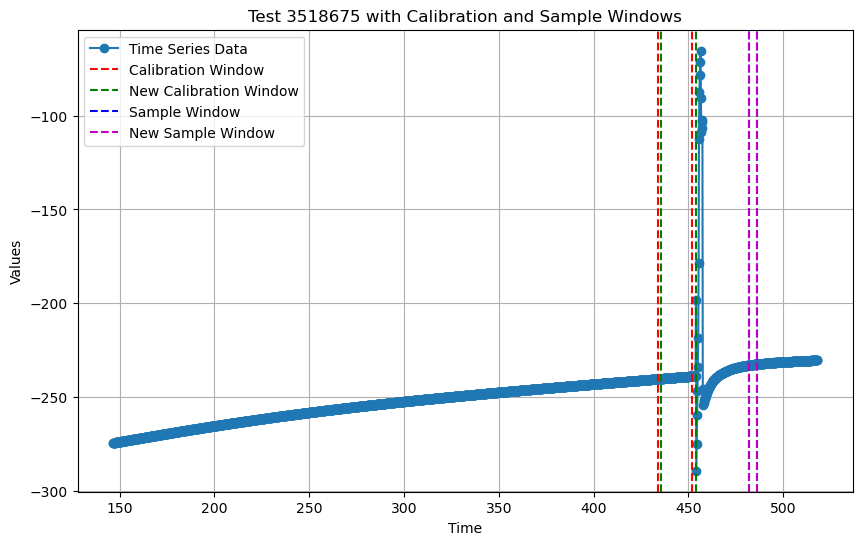

In [56]:
# Random sample one TestID for sensor B in System 2
randomTestID=B2_Merged['TestID'].sample(1).values[0]
if B2_Merged[B2_Merged['TestID']==randomTestID]['FluidType'].str.startswith('Eurotrol').values[0]:
    plot_singletest_with_windows(B2_Merged,randomTestID,calDelimit=18,
                             sampleDelimit=32.8, # For aqueous 
                             cal_window_size=cal_window_size_B,sample_window_size=sample_window_size_B)
else:
    plot_singletest_with_windows(B2_Merged,randomTestID,calDelimit=18,
                                 sampleDelimit=24, # For blood
                                 cal_window_size=cal_window_size_B,
                                sample_window_size=sample_window_size_B)

# 6 Design of Experiment